In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sndata = pd.read_csv('./Data/parsonage.txt', sep = ' ', engine='python')

In [3]:
results = np.load(f'./Results/MCMC_curved_SN+BAO_0.npy'), np.load(f'./Results/MCMC_curved_SN+BAO_1.npy'), np.load(f'./Results/MCMC_curved_SN+BAO_2.npy'), np.load(f'./Results/MCMC_curved_SN+BAO_3.npy')
burn_in = 1000
MCMC_fin = np.concatenate((results[0][:, burn_in:], results[1][:, burn_in:], results[2][:, burn_in:], results[3][:, burn_in:]), axis=1)
Best_fit = MCMC_fin[:,np.argmax(MCMC_fin[-1])]

In [58]:
!pip install --upgrade findiff

DEPRECATION: Loading egg at /home/john1256/anaconda3/lib/python3.12/site-packages/vast-1.4.2-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/john1256/anaconda3/lib/python3.12/site-packages/pyopengltk-0.0.4-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/john1256/anaconda3/lib/python3.12/site-packages/vispy-0.14.3-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/john1256/anaconda3/lib/python3.12/site-packages

In [208]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from findiff import Diff
def integrand(a, parm):
    Ez2 = (parm[0] / (a**3) + parm[1] + (1-parm[0]-parm[1]) /(a**2))
    negative_Ez2_ind = Ez2 < 0
    Ez = np.zeros_like(a)
    Ez[negative_Ez2_ind] = -np.sqrt(-Ez2[negative_Ez2_ind])
    Ez[~negative_Ez2_ind] = np.sqrt(Ez2[~negative_Ez2_ind])
    return Ez

In [210]:
a = np.linspace(0.01, 10, 1000)
Ea = integrand(a, Best_fit)
crit_point = fsolve(integrand, 1.0, args=(Best_fit,))

In [211]:
crit_point

array([1.32342052])

In [214]:
# calculate the age of the universe with respect to the evolution of the scale factor
# we want to get the graph of the evolution of a with respect to the H0*t
from scipy.integrate import quad

def integrand_age(a, parm):
    Ez2 = (parm[0] / (a**3) + parm[1] + (1-parm[0]-parm[1]) /(a**2))
    return 1/np.sqrt(Ez2)

def AgeofUniverse(a,parm, turn_over = False):
    if turn_over==False: # if the universe hasn't turned over yet
        I = quad(integrand_age, 0,a, args= (parm))[0]
    else: # if the universe has experienced a turn over
        I = quad(integrand_age,0,crit_point[0], args=(parm))[0]
        I += quad(integrand_age, a, crit_point[0], args=(parm))[0]
    return I

In [216]:
Turnover_before = np.linspace(0, crit_point[0], 100)
Turnover_after = np.linspace(crit_point[0], 1, 100)

In [217]:
AgeofUniverse(1.3, Best_fit, turn_over=False)

0.9060161712790558

/tmp/ipykernel_1535/4274298178.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  Ez2 = (parm[0] / (a**3) + parm[1] + (1-parm[0]-parm[1]) /(a**2))
/tmp/ipykernel_1535/4274298178.py:6: RuntimeWarning: invalid value encountered in scalar add
  Ez2 = (parm[0] / (a**3) + parm[1] + (1-parm[0]-parm[1]) /(a**2))
/tmp/ipykernel_1535/4274298178.py:11: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  I = quad(integrand_age, 0,a, args= (parm))[0]


Text(0.5, 1.0, 'Evolution of the Universe with respect to H0*t')

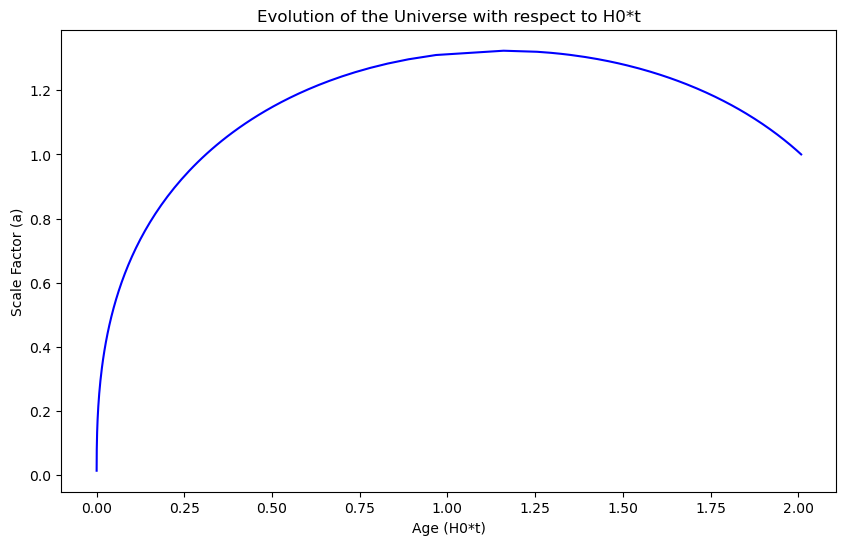

In [218]:
AgeofUniverse_before = np.array([AgeofUniverse(a, Best_fit[:2], turn_over=False) for a in Turnover_before])
AgeofUniverse_after = np.array([AgeofUniverse(a, Best_fit[:2], turn_over=True) for a in Turnover_after])
AgeofUniverse_total = np.concatenate((AgeofUniverse_before, AgeofUniverse_after))
plt.figure(figsize=(10, 6))
plt.plot(AgeofUniverse_total,np.concatenate((Turnover_before, Turnover_after)), label='Age of Universe', color='blue')
plt.xlabel('Age (H0*t)')
plt.ylabel('Scale Factor (a)')
plt.title('Evolution of the Universe with respect to H0*t')
